In [12]:
import pandas as pd
from itertools import chain
from collections import Counter
import os
from utils import load_json_config

In [13]:
config = load_json_config("config.json")

## Downloading a small or a large dataset

### SMALL (~2k records)

In [ ]:
!gdown {config["small_dataset_csv"]}

### LARGE (~26k records)

In [6]:
!gdown {config["large_dataset_csv"]}

Downloading...
From: https://drive.google.com/uc?id=1Up0kFTtyaz-CoiHIKoYAmfdLK7voK6xl
To: /home/yehor/Desktop/Genre_based_on_album_cover/large_dataset.csv
100%|██████████████████████████████████████| 3.10M/3.10M [00:00<00:00, 10.9MB/s]


## Downloading a small or large set of imgs associated with the dataset

### SMALL (~180mb)

In [ ]:
!gdown {config["small_dataset_imgs"]}

### LARGE (~1.5gb)

In [ ]:
!gdown {config["large_dataset_imgs"]}

NOTE: YOU HAVE TO ALTER THE PATH BELOW BASED ON WHEREVER YOU DOWNLOADED THE DATA

In [ ]:
!unzip -o /home/yehor/Desktop/Genre_based_on_album_cover/large_dataset_imgs.zip > /dev/null

NOTE: YOU HAVE TO ALTER THE PATH BELOW BASED ON WHEREVER YOU DOWNLOADED THE DATA

In [37]:
images_location = "/home/yehor/Desktop/Genre_based_on_album_cover/large_cleaned_dataset_imgs"

## Organizing the data

In [38]:
df = pd.read_csv("/home/yehor/Desktop/Genre_based_on_album_cover/large_dataset.csv")
df

,Unnamed: 0,album_index,album_id,genres
0,0,0,5n1GSzC1Reao29ScnpLYqp,"[['florida rap', 'hip hop', 'miami hip hop', '..."
1,1,1,6UYZEYjpN1DYRW0kqFy9ZE,"[['hip hop', 'philly rap', 'pop', 'pop rap', '..."
2,2,2,7uVimUILdzSZG4KKKWToq0,"[['adult standards', 'canadian pop', 'lounge',..."
3,3,3,35s58BRTGAEWztPo9WqCIs,[[]]
4,4,4,41GuZcammIkupMPKH2OJ6I,"[['pop', 'pop rap', 'rap']]"
...,...,...,...,...
26172,26172,26172,5lXF6AFeXG8UsIUfBJNsNH,"[['adult standards', 'easy listening', 'lounge..."
26173,26173,26173,4ceeeNqKJ9OtF33DaHQuum,"[['adult standards', 'bebop', 'bossa nova', 'c..."
26174,26174,26174,1G8AfOjrE0FO9w1gfemIy1,"[['baroque pop', 'brill building pop', 'folk r..."
26175,26175,26175,62usLEsQho4s5TCfa6Ks4s,"[['adult standards', 'bebop', 'big band', 'coo..."


Deleting the images whose records are not present in the .csv file (if any)

In [39]:
df = df[df['album_index'].apply(lambda x: os.path.exists(f"{images_location}/{x}.jpg"))]

In [40]:
df

,Unnamed: 0,album_index,album_id,genres
0,0,0,5n1GSzC1Reao29ScnpLYqp,"[['florida rap', 'hip hop', 'miami hip hop', '..."
1,1,1,6UYZEYjpN1DYRW0kqFy9ZE,"[['hip hop', 'philly rap', 'pop', 'pop rap', '..."
2,2,2,7uVimUILdzSZG4KKKWToq0,"[['adult standards', 'canadian pop', 'lounge',..."
3,3,3,35s58BRTGAEWztPo9WqCIs,[[]]
4,4,4,41GuZcammIkupMPKH2OJ6I,"[['pop', 'pop rap', 'rap']]"
...,...,...,...,...
26172,26172,26172,5lXF6AFeXG8UsIUfBJNsNH,"[['adult standards', 'easy listening', 'lounge..."
26173,26173,26173,4ceeeNqKJ9OtF33DaHQuum,"[['adult standards', 'bebop', 'bossa nova', 'c..."
26174,26174,26174,1G8AfOjrE0FO9w1gfemIy1,"[['baroque pop', 'brill building pop', 'folk r..."
26175,26175,26175,62usLEsQho4s5TCfa6Ks4s,"[['adult standards', 'bebop', 'big band', 'coo..."


Now proceeding to merging the branches of genres into the parent genres

In [41]:
maps = load_json_config("binary_classification.json")

In [42]:
indexed_categories = maps["indexed_categories"]
keyword_to_category = maps["keyword_to_category"]

In [43]:
def extract_genres(genres):
    return list(chain.from_iterable(eval(genres)))

In [44]:
def parent_genre(sub_genre):
    if not sub_genre or not isinstance(sub_genre, str):
        return "unknown"
    
    sub_genre = sub_genre.lower()
    for keyword, category in keyword_to_category.items():
        if keyword in sub_genre:
            return category
    
    return "unknown"

In [82]:
def assign_genre(sub_genres):
    genre_counts = Counter([parent_genre(sub_genre) for sub_genre in sub_genres])
    if len(genre_counts) == 0:
        return "unknown"
    return max(genre_counts.items(), key=lambda item: item[1])[0]  # return the genre with max count

In [46]:
cleaned_df = pd.DataFrame({"album_id": pd.Series(dtype="int"), "genre": pd.Series(dtype="int")})
for row in df.itertuples(index=True, name="Row"):
    genre = assign_genre(extract_genres(row.genres))
    if genre == "unknown":
        continue
    new_row = pd.DataFrame([{"album_id": int(row.album_index), "genre": indexed_categories[genre]}])
    cleaned_df = pd.concat([cleaned_df, new_row], ignore_index=True)

cleaned_df

,album_id,genre
0,4,0
1,6,1
2,12,0
3,14,1
4,16,1
...,...,...
10257,26164,1
10258,26168,0
10259,26169,0
10260,26171,1


In [47]:
cleaned_df["genre"].value_counts()

genre
1    7393
0    2869
Name: count, dtype: int64

In [48]:
cleaned_df.to_csv(config["organized_dataset_name"], index=False)

## Balancing the cleaned dataset (OPTIONAL)

In [49]:
# count occurrences of each genre
genre_counts = cleaned_df['genre'].value_counts()

# find the count of the least represented genre
min_count = genre_counts.min()

# sample each genre to match the least represented genre's count
balanced_df = pd.concat(
    [cleaned_df[cleaned_df['genre'] == genre].sample(n=min_count, random_state=43) for genre in genre_counts.index]
)

# shuffle the balanced DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [50]:
balanced_df["genre"].value_counts()

genre
0    2869
1    2869
Name: count, dtype: int64

Save the balanced dataset as a .csv file:

In [51]:
balanced_df.to_csv(config["organized_balanced_dataset_name"], index=False)

## Checking for potential mislabeling (OPTIONAL)

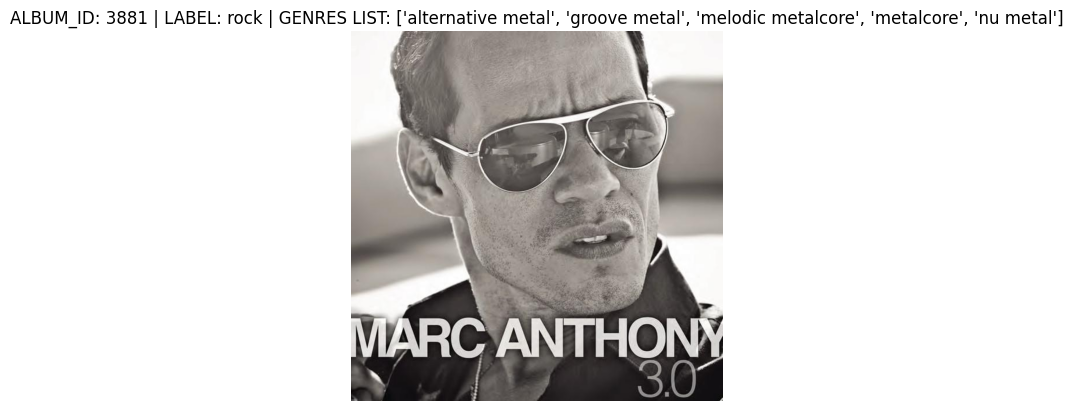

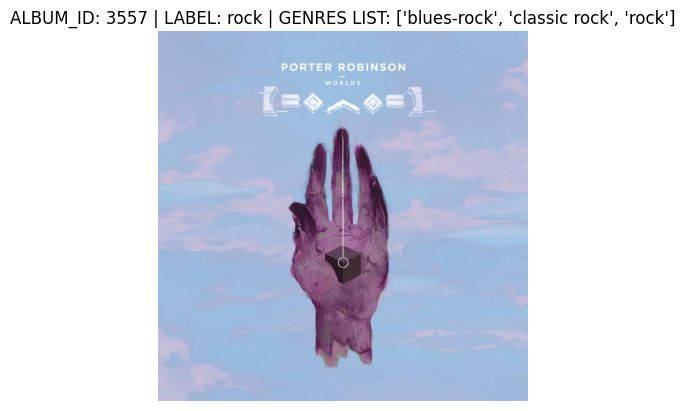

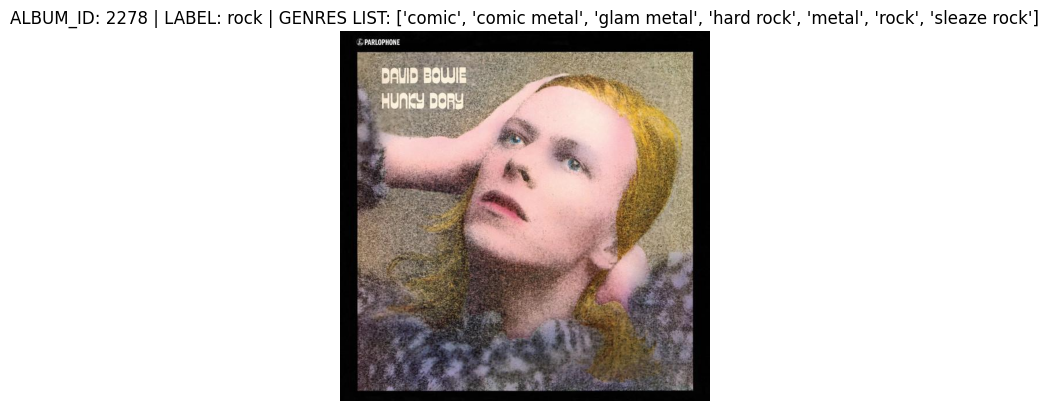

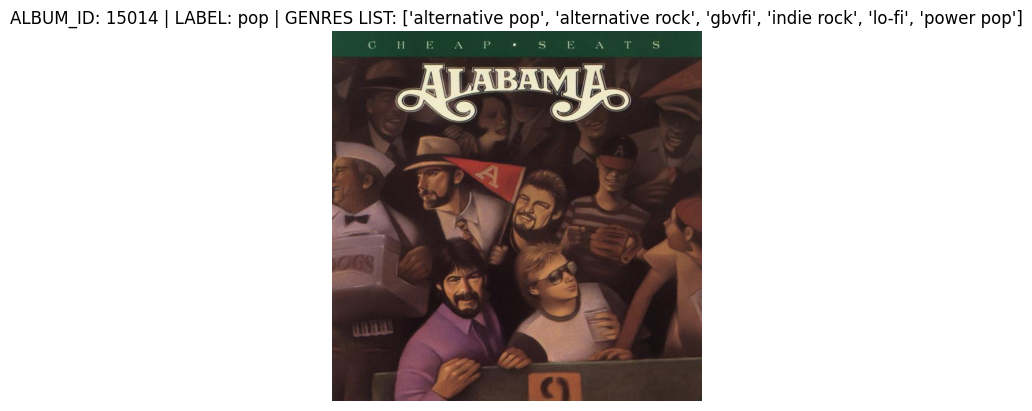

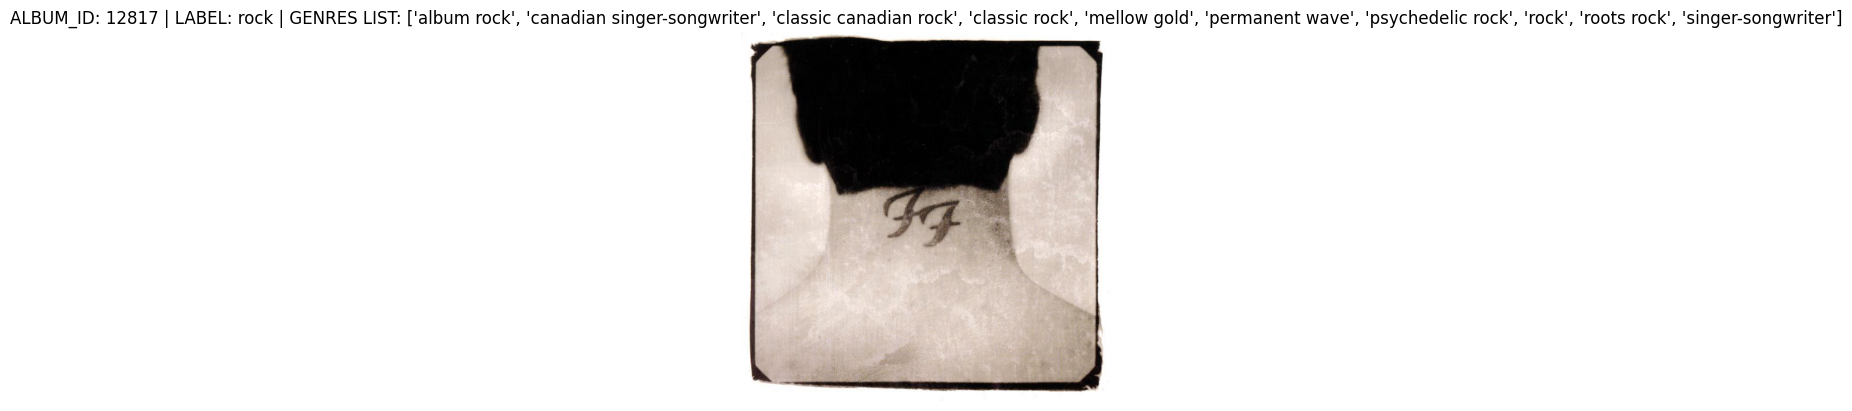

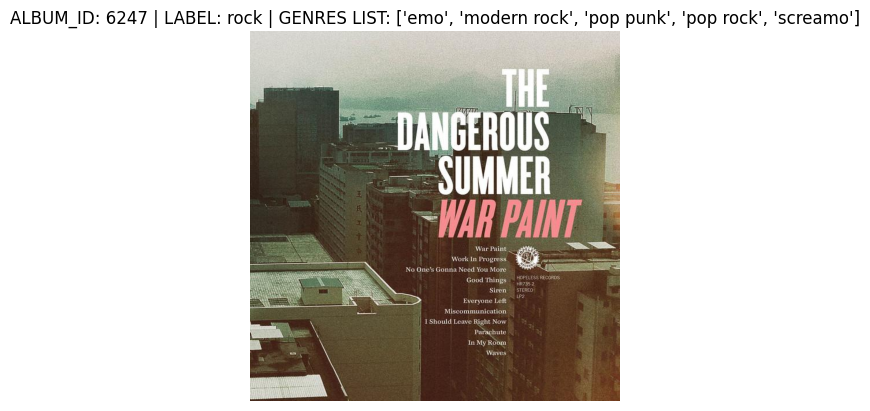

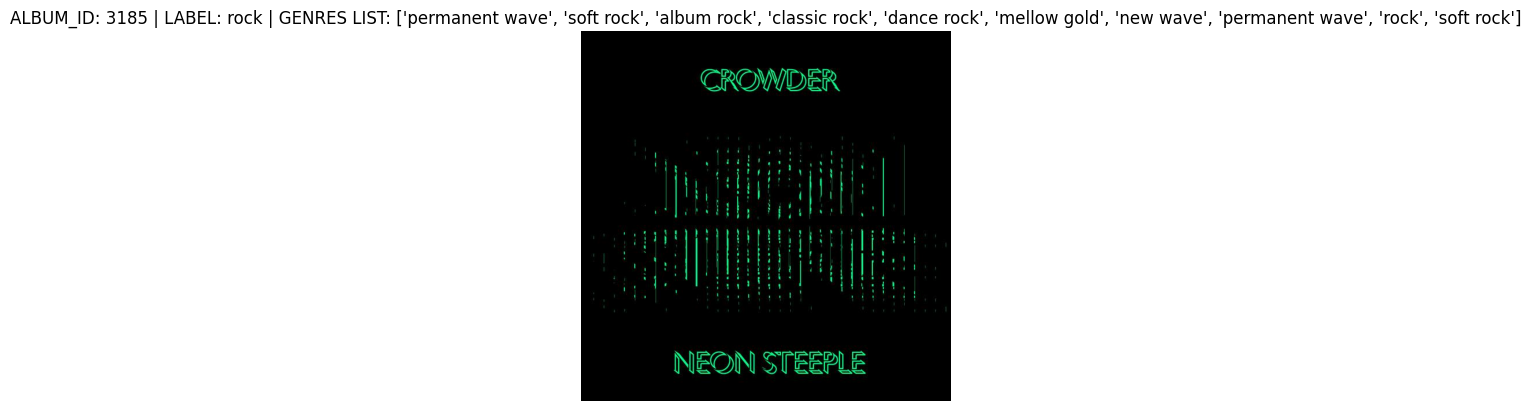

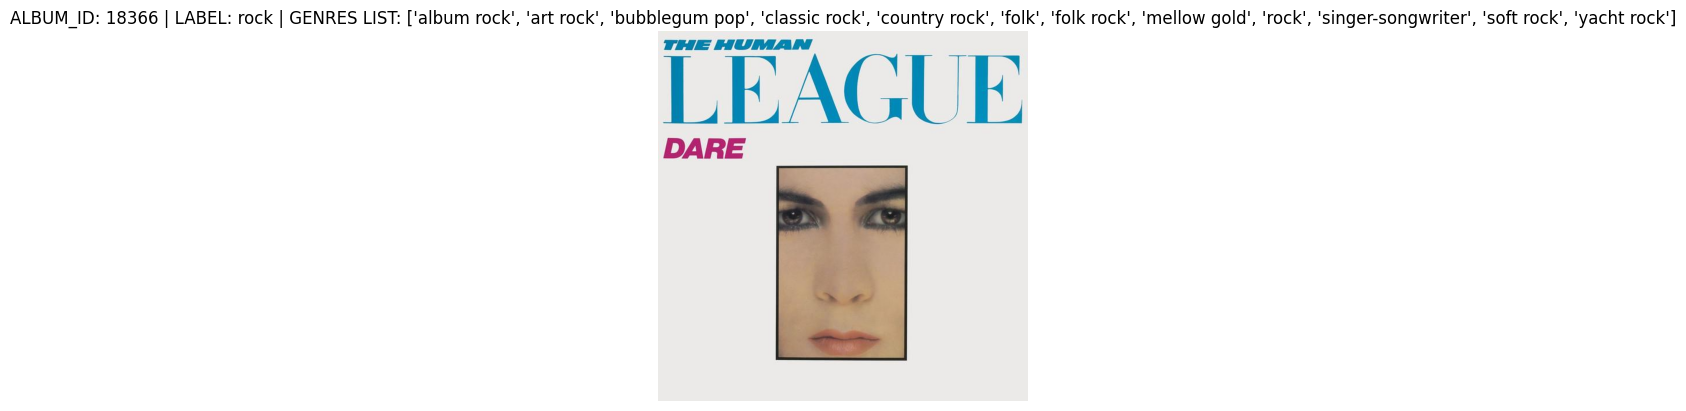

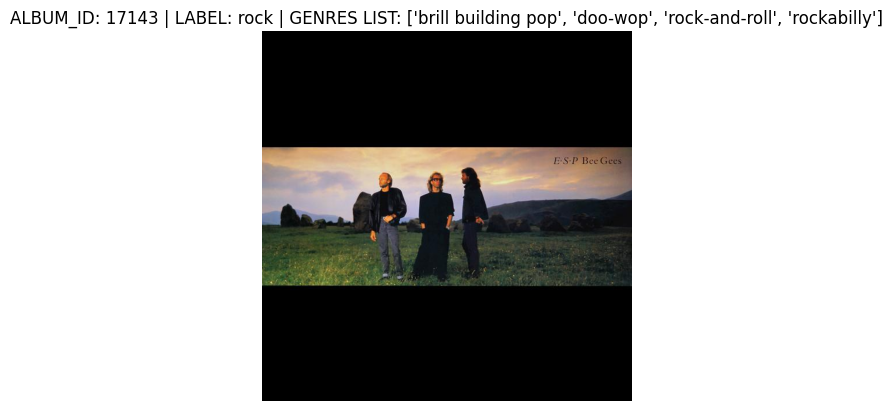

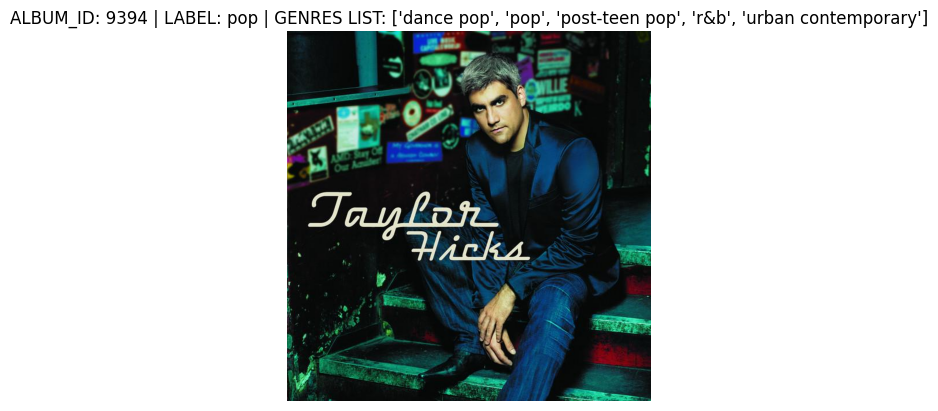

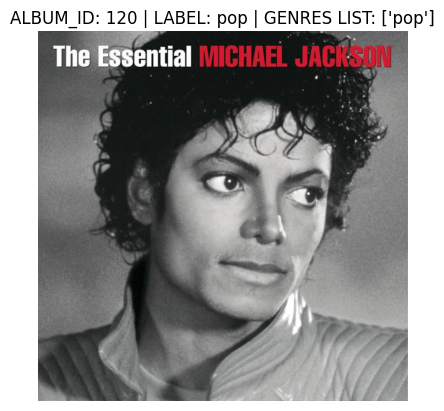

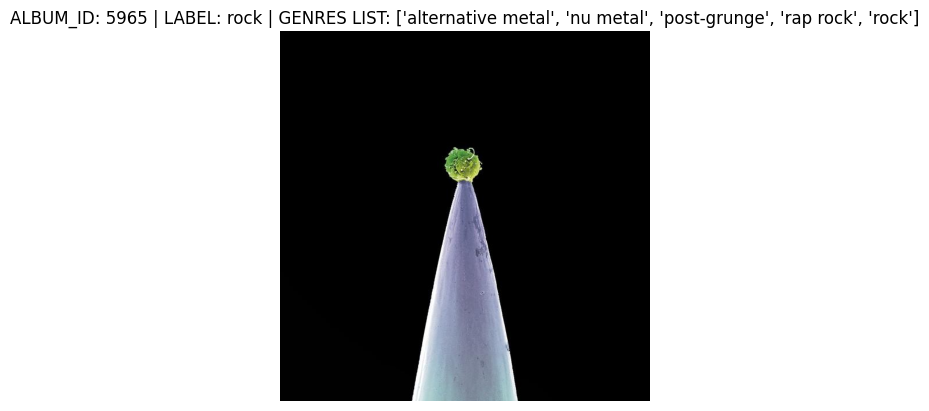

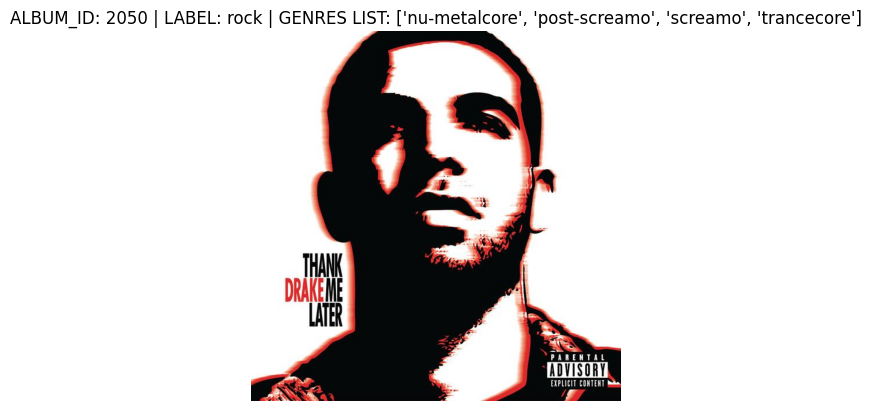

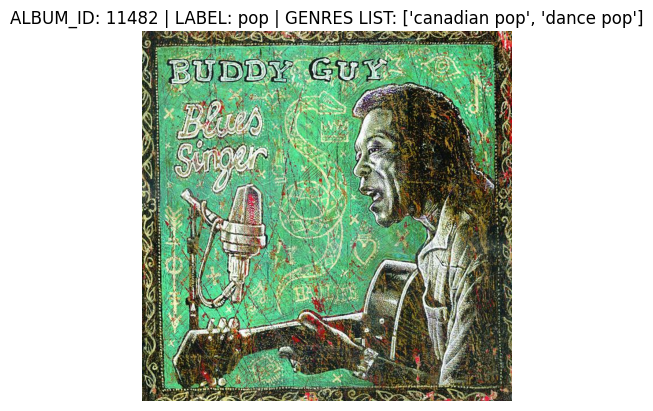

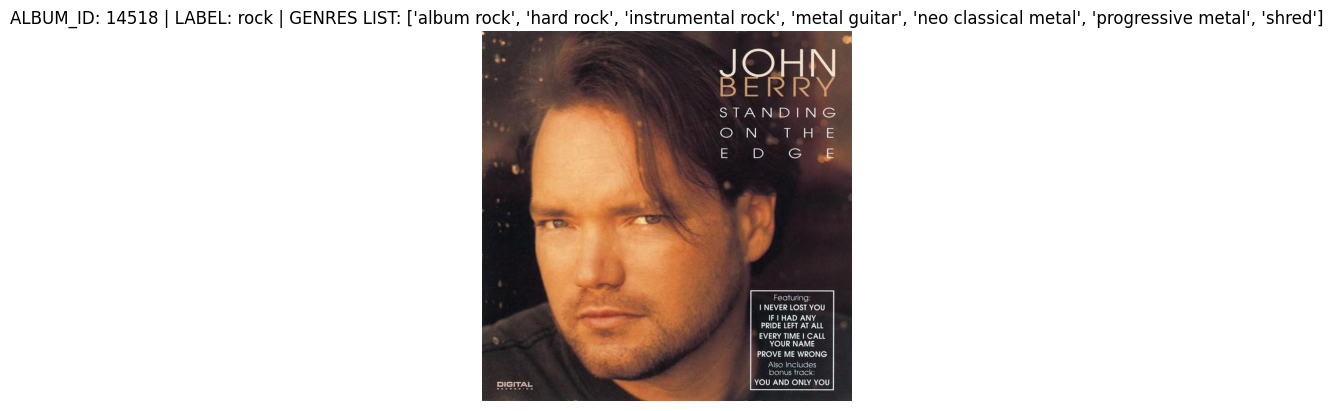

In [86]:
import random
from matplotlib import pyplot as plt
from PIL import Image

# create the inverse map for the genres and their indices
categories_indexed = {v: k for k, v in indexed_categories.items()}

sample_df = balanced_df.sample(15, random_state=44)
for _, row in sample_df.iterrows():
    album = df['album_index'] == row['album_id']
    image = Image.open(f"{images_location}/{row['album_id']}.jpg")
    plt.imshow(image)
    genres_list = extract_genres(df.loc[album,'genres'].iloc[0])
    plt.title(f"ALBUM_ID: {row['album_id']} | LABEL: {categories_indexed[row['genre']]} | GENRES LIST: {genres_list}")
    plt.axis("off")
    plt.show()